# Classificação de Imagens com CNN usando CIFAR-10
Este notebook apresenta o processo de construção, treinamento e validação de uma rede neural convolucional (CNN) para a classificação de imagens usando a base de dados CIFAR-10. Em cada seção, descrevemos as etapas e os objetivos principais do processo:


1.   **Importação e Visualização dos Dados:** Carregamos o dataset CIFAR-10 e exibimos algumas imagens para entender as classes disponíveis e a estrutura dos dados.

2.   **Construção da Arquitetura da Rede Neural:** Criamos a CNN com camadas convolucionais, pooling e totalmente conectadas, projetadas para capturar padrões complexos em imagens.

3.   **Configuração e Treinamento do Modelo:** Definimos os parâmetros de treinamento, realizamos o ajuste do modelo e monitoramos o progresso em cada época.

4.   **Avaliação do Modelo:** Calculamos a matriz de confusão para examinar o desempenho em cada classe do dataset.
Plotamos gráficos de accuracy e loss para comparar o desempenho nas fases de treino e validação ao longo das épocas.

5.   **Visualização dos Mapas de Características:** Mostramos mapas de características das camadas convolucionais, evidenciando o que a CNN aprende a extrair das imagens.

6.   **Predição de Imagens Externas:** Permitimos que o usuário insira uma imagem externa para que o modelo faça uma previsão, demonstrando a aplicação prática da rede.


*Este notebook foi desenvolvido como parte da aplicação prática dos conhecimentos adquiridos na pós-graduação em Inteligência Artificial e Aprendizado de Máquina. Ele demonstra o uso de redes neurais convolucionais para classificação de imagens, com exemplos visuais e interpretação dos resultados obtidos.*

# Importação e Visualização dos Dados

In [3]:
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.models import Model
from google.colab import files

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [5]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [6]:
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

class_names = ['avião', 'carro', 'pássaro', 'gato', 'cervo', 'cachorro', 'sapo', 'cavalo', 'navio', 'caminhão']

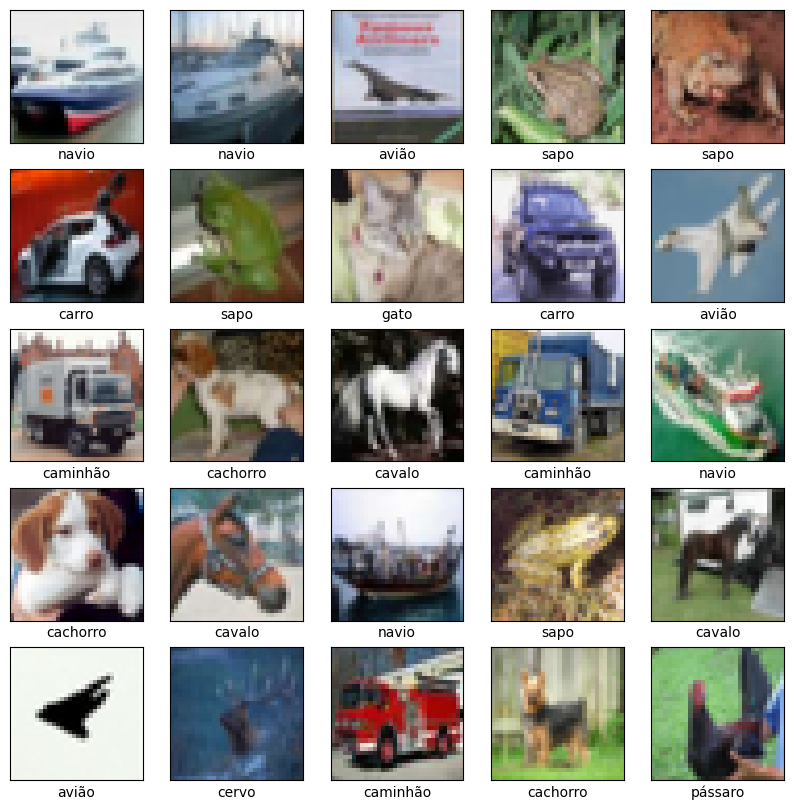

In [9]:
plt.figure(figsize=(10,10))
for i in range(1, 26):
    plt.subplot(5, 5, i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i])
    plt.xlabel(class_names[int(y_test[i].argmax())])
plt.show()

# Construção da Arquitetura da Rede Neural

In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1)
])

In [11]:
model = tf.keras.Sequential([
    data_augmentation,

    tf.keras.layers.Conv2D(64, (2,2), input_shape=(32, 32, 3), padding='valid', kernel_initializer='he_normal', bias_initializer='zeros'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Conv2D(128, (3,3), padding='valid', kernel_regularizer=tf.keras.regularizers.l2(), kernel_initializer='he_normal', bias_initializer='zeros'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (2,2), padding='valid', kernel_initializer='he_normal', bias_initializer='zeros'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Conv2D(256, (1,1), padding='valid', kernel_regularizer=tf.keras.regularizers.l2()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Flatten(),

    #tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2()),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2()),

    tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='glorot_normal')


])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Configuração e Treinamento do Modelo

In [12]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    clipnorm=1.0,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=30,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=10,
        min_lr=1e-6,
        verbose=1
    )
]

In [13]:
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [14]:
history = model.fit(
    x_train, y_train,
    epochs=200,
    batch_size=128,
    validation_data=(x_val, y_val),
    callbacks= callbacks
    )

Epoch 1/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.1984 - loss: 6.2060
Epoch 1: val_loss improved from inf to 2.68565, saving model to best_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.1985 - loss: 6.1994 - val_accuracy: 0.2714 - val_loss: 2.6857 - learning_rate: 0.0010
Epoch 2/200
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2882 - loss: 2.4480
Epoch 2: val_loss improved from 2.68565 to 2.10232, saving model to best_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.2883 - loss: 2.4474 - val_accuracy: 0.4340 - val_loss: 2.1023 - learning_rate: 0.0010
Epoch 3/200
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3401 - loss: 2.2229
Epoch 3: val_loss did not improve from 2.10232
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.3402 - loss: 2.2229 - val_accuracy: 0.3662 - val_loss: 2.2013 - learning_rate: 0.0010
Epoch 4/200
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3806 - loss: 2.1504
Epoch 

In [15]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 31, 31, 64)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 31, 31, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 29, 29, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 29, 29, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 13, 13, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 13, 13, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 256)         │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 13, 13, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 43264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       5,537,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 17,017,056 (64.91 MB)

 Trainable params: 5,672,010 (21.64 MB)

 Non-trainable params: 1,024 (4.00 KB)

 Optimizer params: 11,344,022 (43.27 MB)

# Avaliação do Modelo

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7255 - loss: 0.9507
Test Loss: 0.9422
Test Accuracy: 0.7234
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


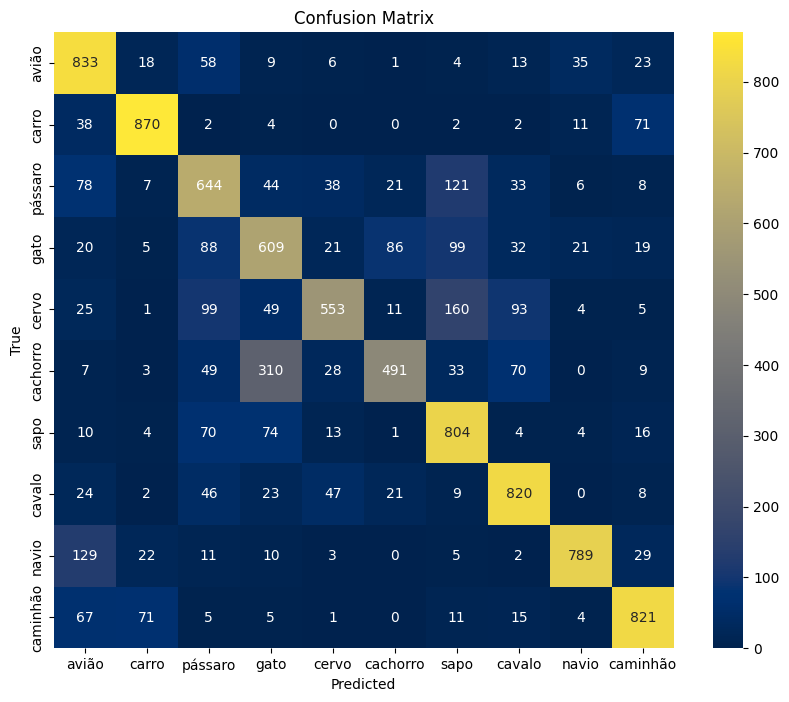

In [16]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='cividis', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [17]:
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

Classification Report:

              precision    recall  f1-score   support

       avião       0.68      0.83      0.75      1000
       carro       0.87      0.87      0.87      1000
     pássaro       0.60      0.64      0.62      1000
        gato       0.54      0.61      0.57      1000
       cervo       0.78      0.55      0.65      1000
    cachorro       0.78      0.49      0.60      1000
        sapo       0.64      0.80      0.72      1000
      cavalo       0.76      0.82      0.79      1000
       navio       0.90      0.79      0.84      1000
    caminhão       0.81      0.82      0.82      1000

    accuracy                           0.72     10000
   macro avg       0.74      0.72      0.72     10000
weighted avg       0.74      0.72      0.72     10000



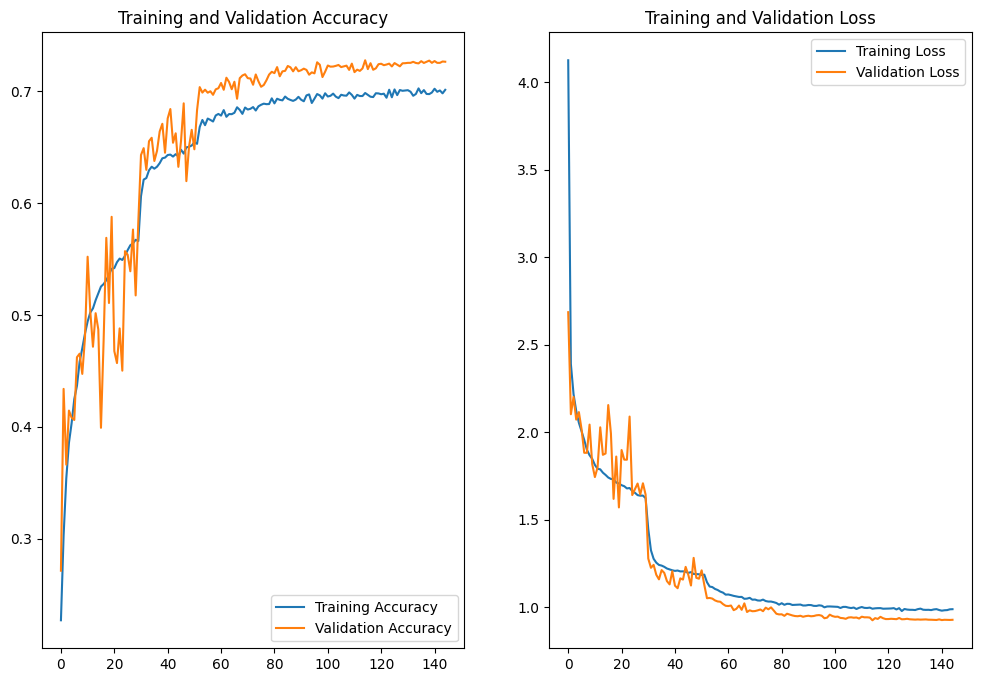

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

# Visualização dos Mapas de Características

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


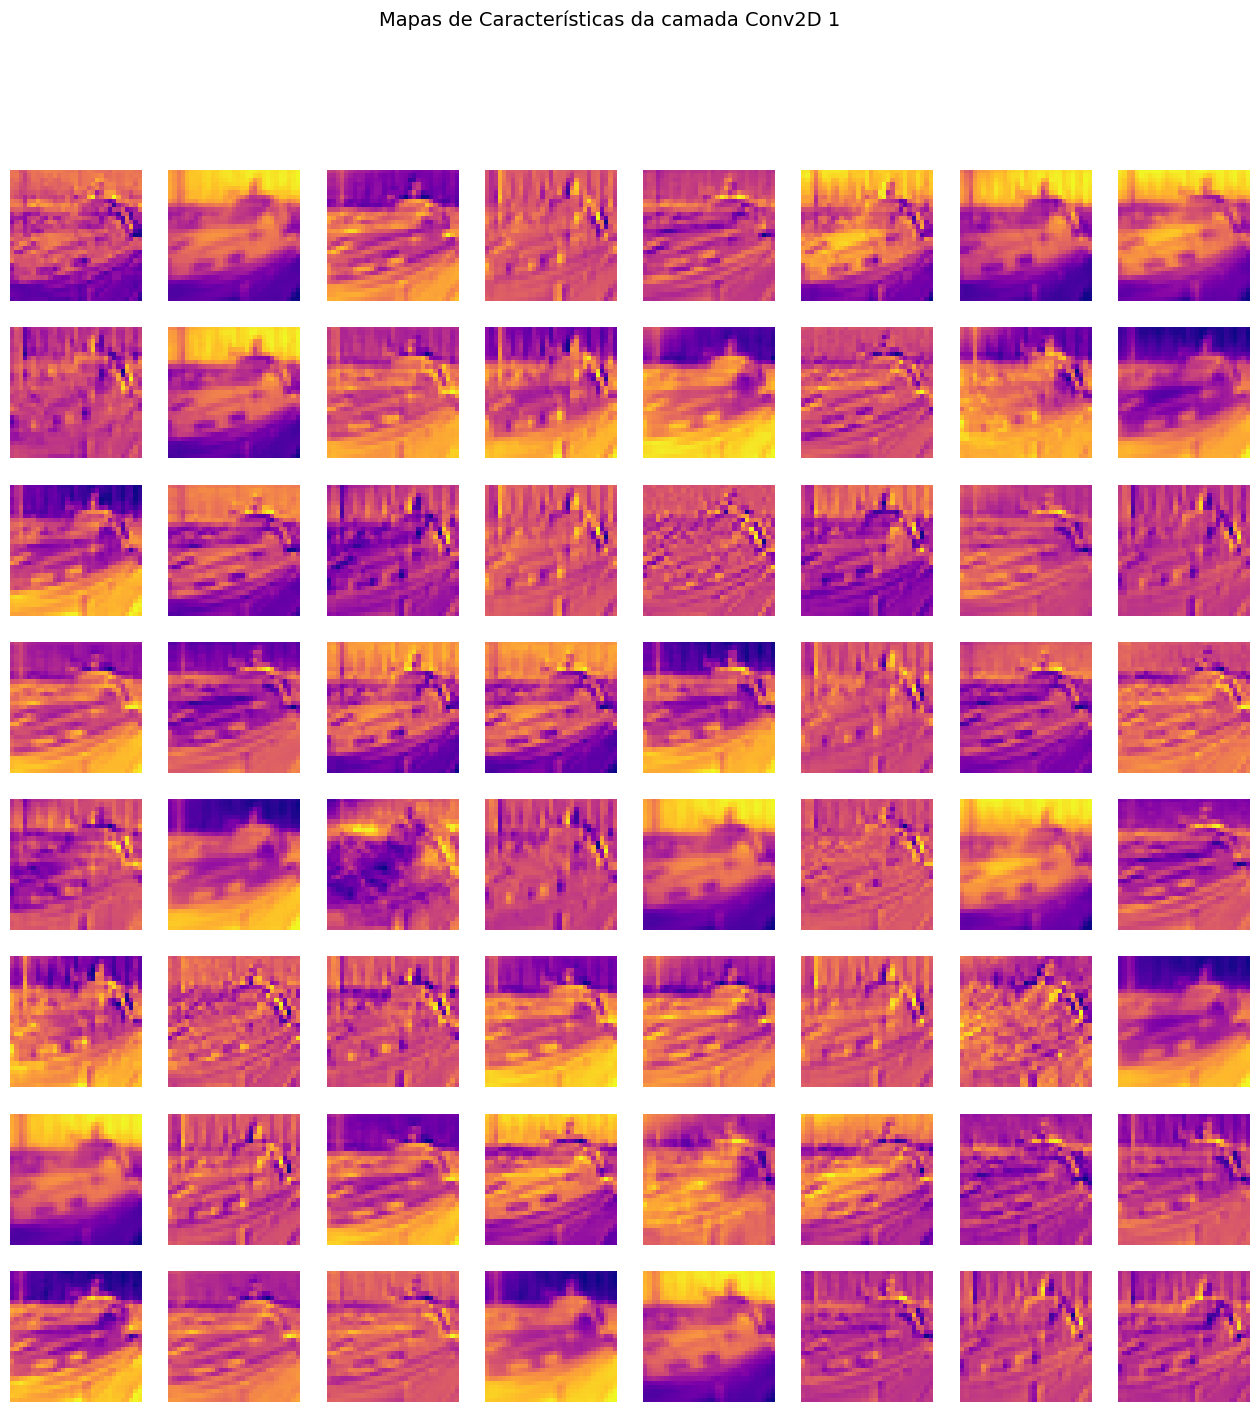

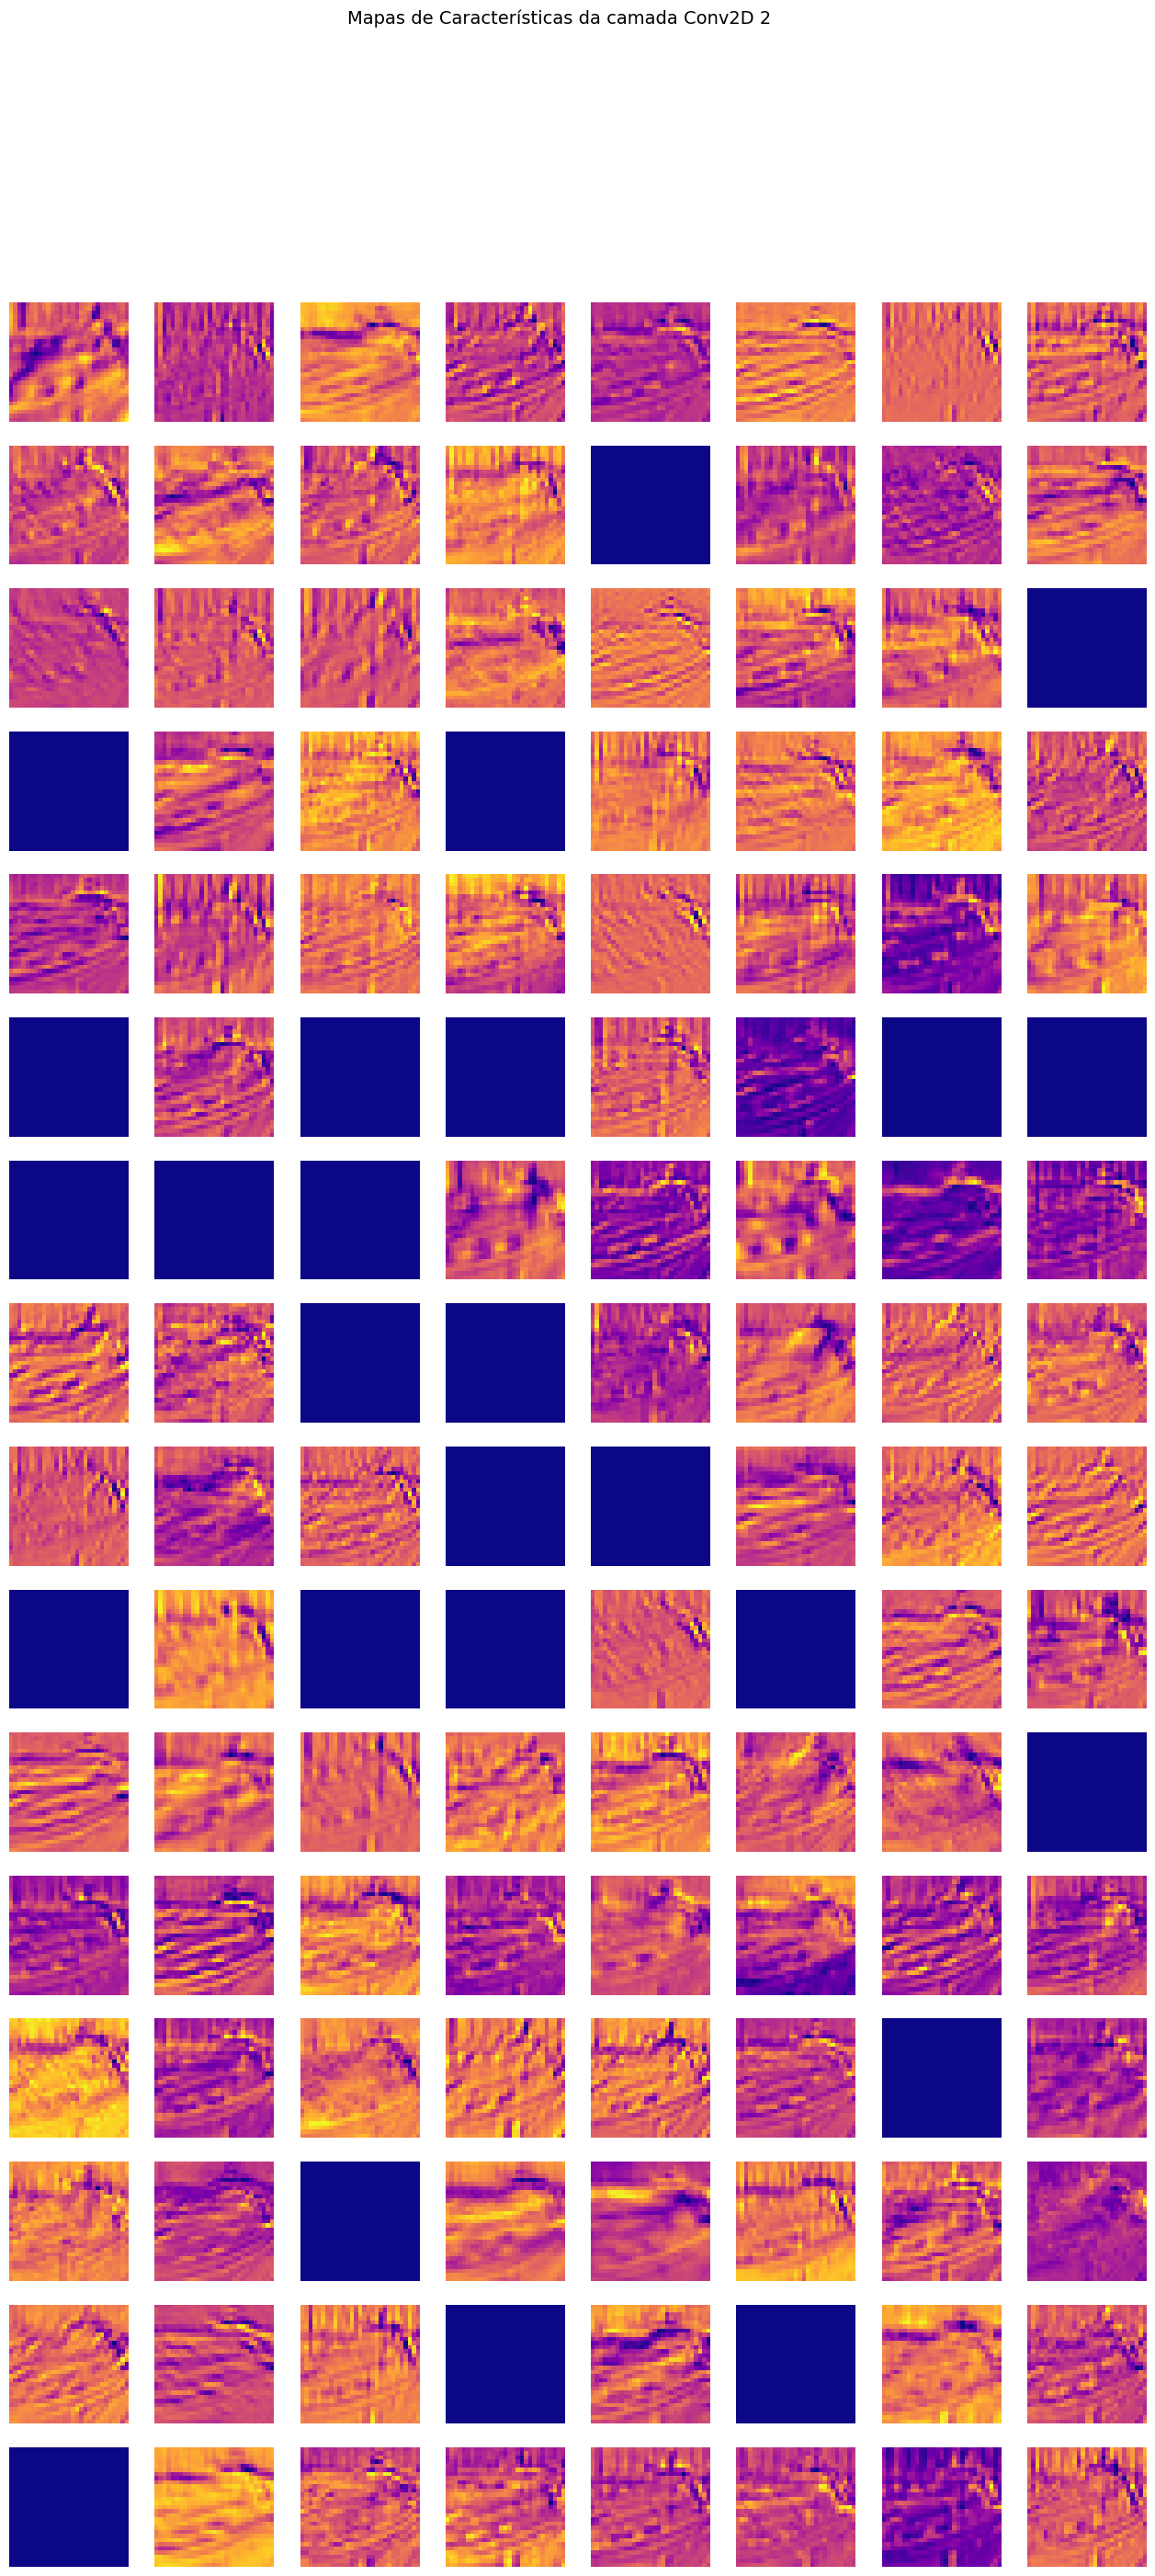

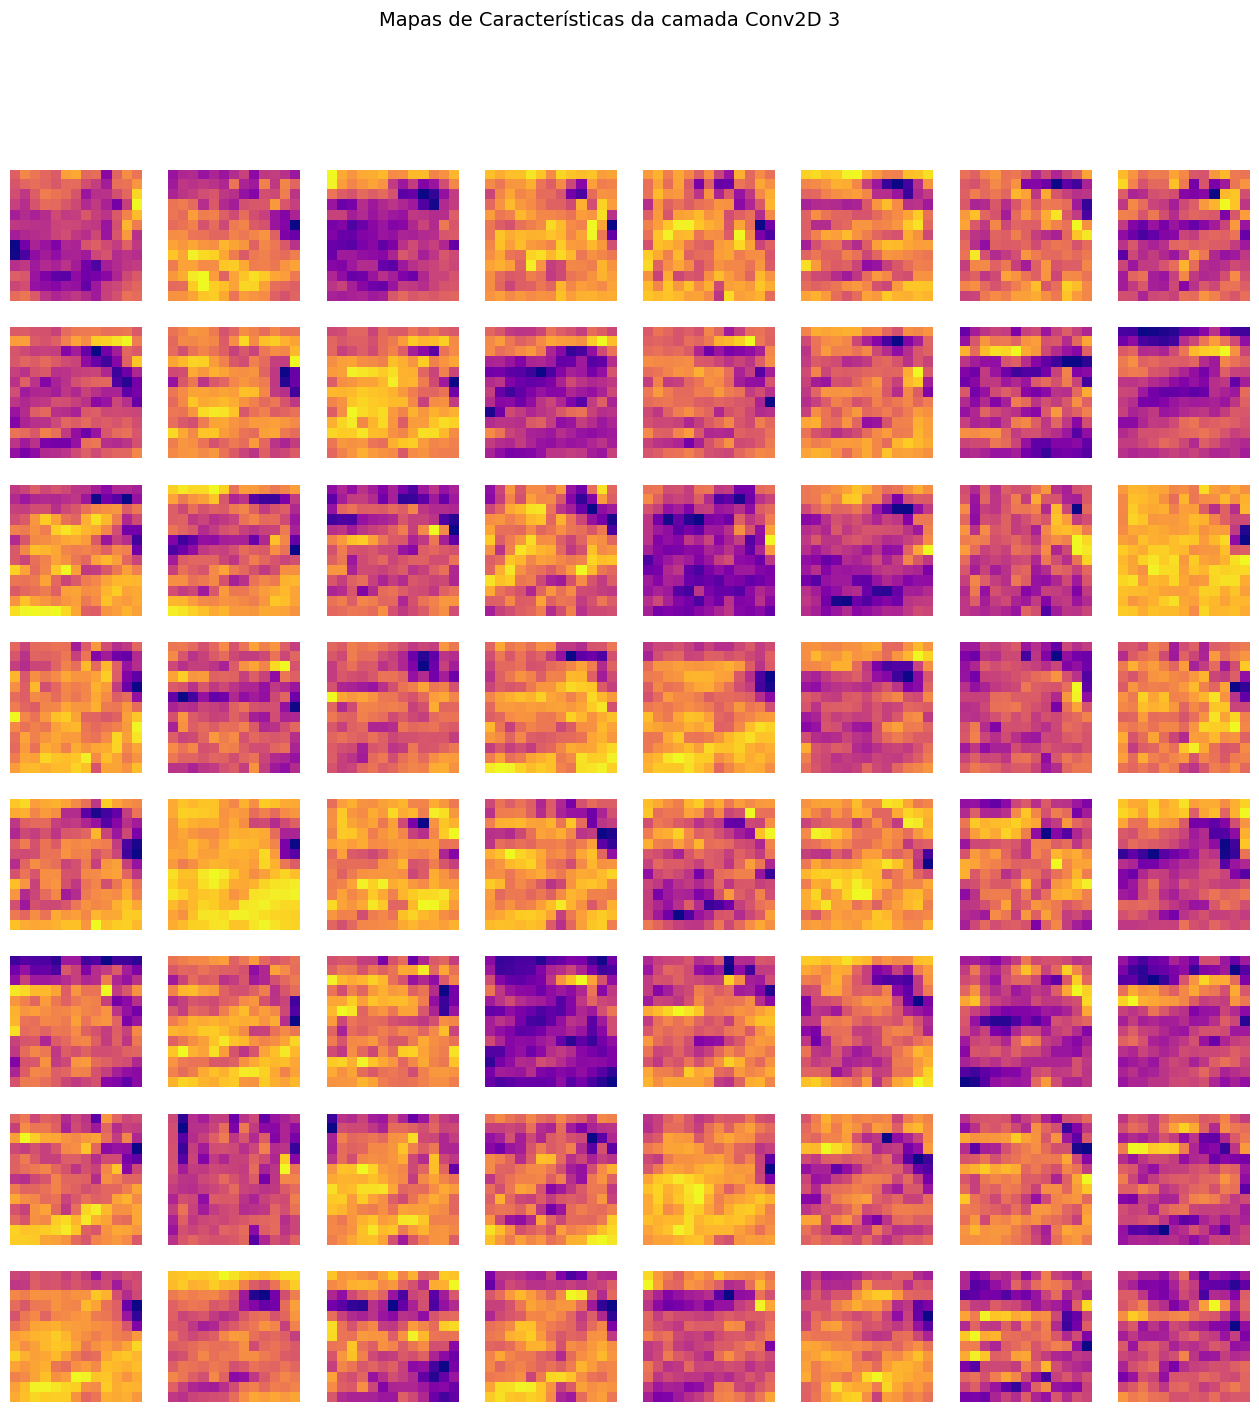

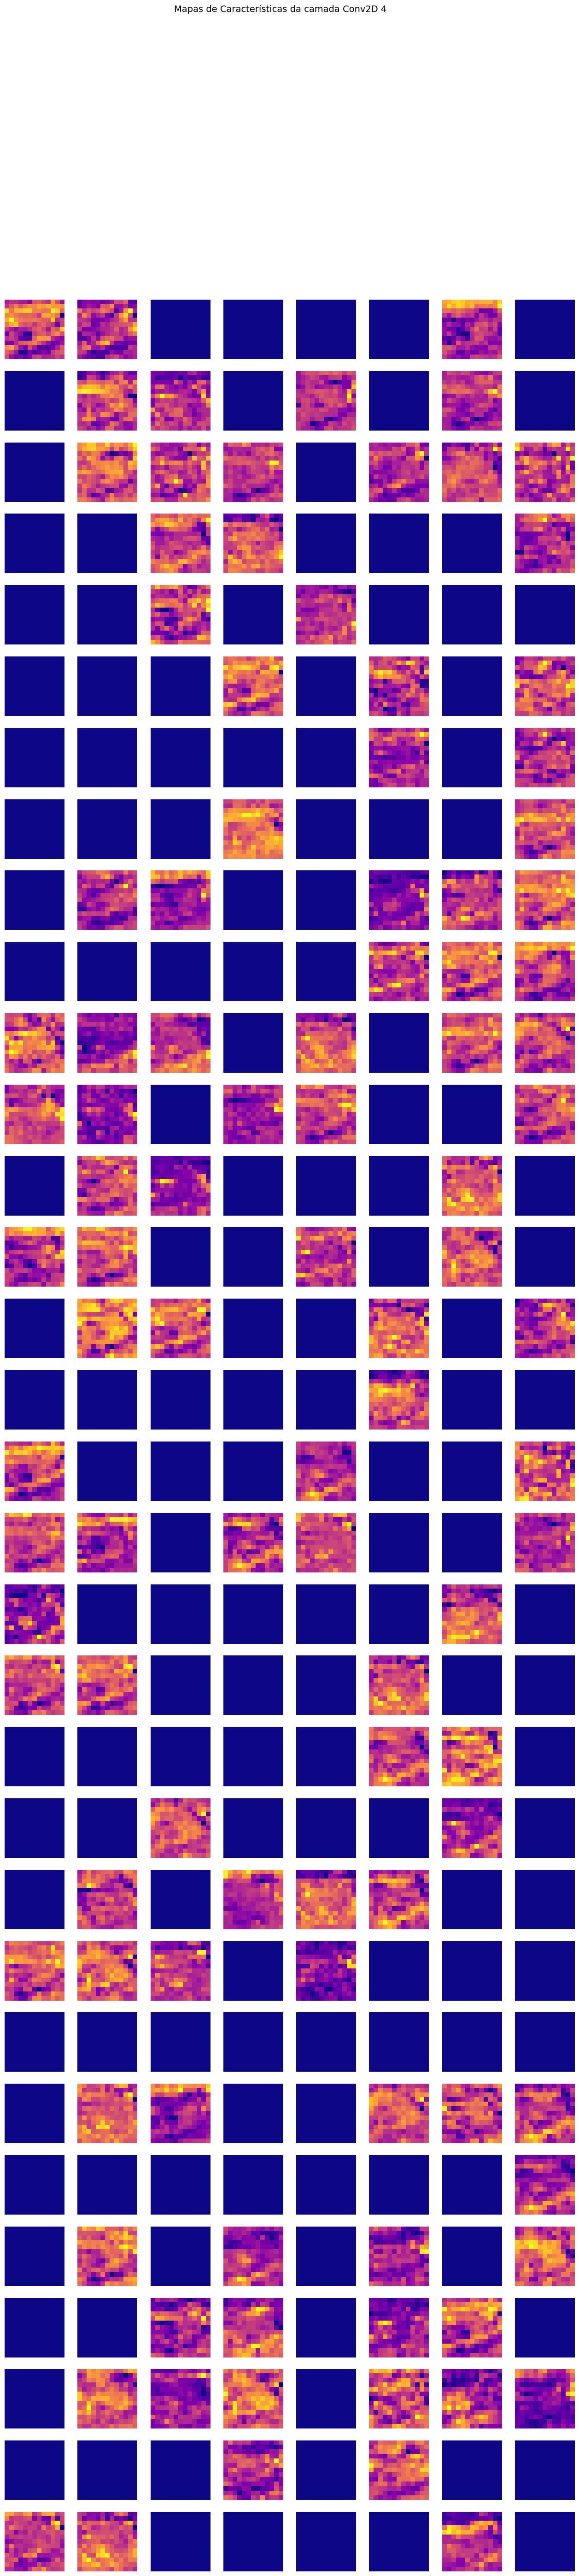

In [25]:
inputs = model.inputs
outputs = [layer.output for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)]

activation_model = Model(inputs=inputs, outputs=outputs)

img = x_test[2]
img = np.expand_dims(img, axis=0)

activations = activation_model.predict(img)

for i, activation in enumerate(activations):
    n_features = activation.shape[-1]
    n_cols = min(n_features, 8)
    n_rows = (n_features + n_cols - 1) // n_cols

    plt.figure(figsize=(n_cols * 2, n_rows * 2))
    for j in range(n_features):
        plt.subplot(n_rows, n_cols, j+1)
        plt.imshow(activation[0, :, :, j], cmap='plasma')
        plt.axis('off')

    plt.suptitle(f'Mapas de Características da camada Conv2D {i+1}', fontsize=14)
    plt.show()


# Predição de Imagens Externas
Experimente baixar uma imagem qualquer da internet e envia-la ao modelo.

Saving imageWeb.jpg to imageWeb.jpg


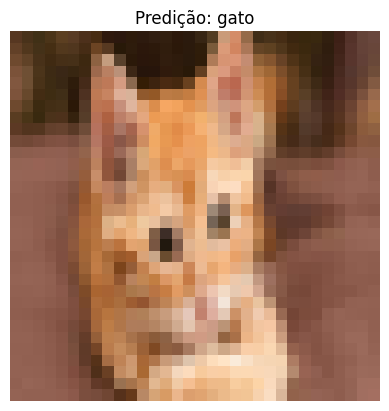

In [24]:
def predict_uploaded_image():
    uploaded = files.upload()

    image_path = list(uploaded.keys())[0]

    img = Image.open(image_path)
    img = img.resize((32, 32))
    img_array = np.array(img)
    img_array = img_array.astype('float32') / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array, verbose=0)
    classe = class_names[np.argmax(pred)]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predição: {classe}')
    plt.show()

predict_uploaded_image()